
# **Bernoulli classifier**

Making accurate predictions about binary outcomes—such as determining whether a signal was received in a communication network—is a common task in engineering workflows. Using Bernoulli's likelihood function, Gaussian Processes (GPs) in `twinLab` offer a powerful and flexible approach to tackling binary classification problems. This combination allows us to capture the underlying probability of a data point belonging to a particular class, enabling more reliable and robust decision-making in engineering applications.

This notebook will cover how to:

1. [Generate data suitable for classification.](#1.-Generate-data-suitable-for-classification)
2. [Upload dataset and train a classification emulator.](#2.-Upload-dataset-and-train-your-emulator)
3. [Predict using a classification emulator.](#3.-Predict-using-a-classification-emulator)
4. [Visualise the results of the prediction of a classification emulator.](#4.-Viewing-the-results)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import twinlab as tl


          ====== TwinLab Client Initialisation ======
          Version     : 2.10.0
          User        : sergio@digilab.co.uk
          Server      : http://127.0.0.1:8000
          Environment : /Users/sergiochavez/twinLab/.env



Make sure you set up your API key and other information to be able to use `twinLab`, either through a `.env` file, using `secrets`, or through `tl.set_user`/`tl.set_api_key`.

### **1. Generate data suitable for classification**

You can use the following code to simulate a dataset that can be used to train a classification GP. Here, the outputs ('y') are either 0 or 1. 

In [ ]:
np.random.seed(123)

# Generate train_x
train_x = np.random.rand(50)

# Generate train_y
train_y = np.sign(np.cos(train_x * (4 * np.pi))).astype(float)
train_y = (train_y + 1) / 2

# True function that underlies the generation of train_x and train_y
x = np.linspace(0, 1, 100)
y = np.sign(np.cos(x * (4 * np.pi))).astype(float)
y = (y + 1) / 2

`twinLab` expects data in the form of a `pandas DataFrame`, so we need to take the data we've generated and convert it to this form. 

In [ ]:
# Convert generated data to pandas dataframe
df = pd.DataFrame({
    "X": train_x,
    "y": train_y
})

Check that the DataFrame looks like you expect it: 

In [2]:
# Display the first few rows of the dataframe
df.head()

,X,y
0,0.696469,0.0
1,0.286139,0.0
2,0.226851,0.0
3,0.551315,1.0
4,0.719469,0.0


To have a better look of the generated data, you can plot it using the following block of code:

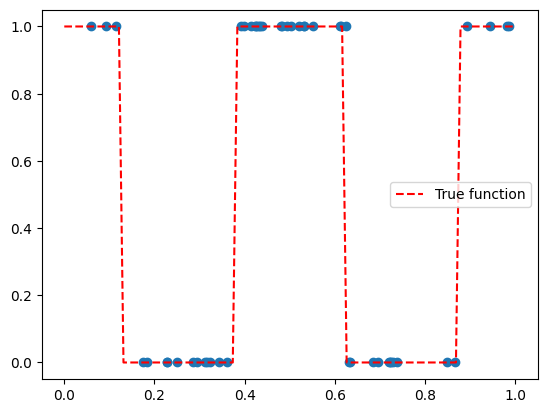

In [3]:
# Plot the generated data
plt.scatter(df['X'], df['y']) # Scatter plot of the generated data
plt.plot(x, y, color='red',linestyle='dashed', label='True function') # Plot of the true function
plt.legend() # Display the legend
plt.show()

Now, you can train a classification `twinLab` model that identifies the patterns underlying the data and approximates the true function that you established in section one (represented by the red dotted line you generated in the plot).

### **2. Upload dataset and train your emulator**

To start training, you will have to specify the type of GP ("classification_gp") inside `tl.EstimatorParams`. 

The rest of the process is the same as the one you would follow to train a standard `twinLab` model, with the one caveat that the output (*y*) takes a binary value. 

Create a `Dataset` with an `id` which is used to access it. Using the `upload` method, you can then upload the `Dataset` to your `twinLab` cloud account.

In [ ]:
# Create a Dataset and upload data
dataset = tl.Dataset(id="classification_df")
dataset.upload(df)

Use the `twinLab` `Emulator` class to define an emulator with an `id`, under which your emulator will be saved as in the `twinLab` cloud.

In [ ]:
# Create an emulator
emulator = tl.Emulator(id="classification_emulator")

When you want to train a model, you pass on your training requirements via arguments using a `TrainParams` object. `TrainParams` is a class that contains all the necessary parameters needed to train your model

In [4]:
# Train emulator
estimator_params = tl.EstimatorParams(estimator_type="classification_gp") # Specify the "classification_gp" estimator
params = tl.TrainParams(estimator_params=estimator_params)
emulator.train(dataset=dataset, inputs=["X"], outputs=["y"], params=params)

Emulator classification_emulator has begun training.
0:00:00: Job status: processing
0:00:01: Job status: processing
0:00:03: Job status: processing
0:00:05: Job status: processing
0:00:08: Job status: processing
0:00:10: Job status: processing
0:00:13: Job status: success
Training of emulator classification_emulator is complete!


### **3. Predict using a classification emulator**

Now, you can use the trained emulator to classify new incoming data. First you need to generate data to use in evaluating our trained emulator: 

In [5]:
# Generate test_x that will be used to evaluate the trained emulator
np.random.seed(5)
eval_x = np.random.rand(10)
eval_df = pd.DataFrame({
    "X": eval_x,
})

Then, the process of running `predict` is exactly the same as the one you would follow for a standard `twinlab` emulator.

In [ ]:
# Classify incoming data using the trained emulator
classification_mean, classification_std= emulator.predict(eval_df, verbose=False)

Now that you've created predictions, let's add it in to your `DataFrame`. 

In [ ]:
# Include the classification mean and std in the eval_df
eval_df["classification_mean"] = classification_mean
eval_df["classification_std"] = classification_std

### **4. Viewing the results**

You can create a plot that displays the mean and standard deviation of the predictions. In this case, we can evaluate how close are those predictions from the true function you want to get close to.

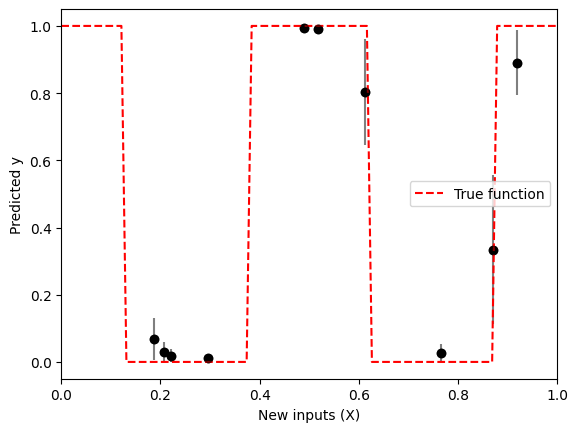

In [6]:
# Plot the classification mean and std
plt.scatter(eval_df["X"], eval_df["classification_mean"], color="black")
# Add in error bars to show your prediction results and quantify the uncertainty in your prediction 
plt.errorbar(eval_df['X'], eval_df['classification_mean'], yerr=eval_df['classification_std'], fmt='o', color="black", alpha=0.5)
# Plot the model you used to generate the data--the true function 
plt.plot(x, y, color='red',linestyle='dashed', label='True function')

# Add in labels and other plot parameters
plt.ylabel("Predicted y")
plt.xlabel("New inputs (X)")
plt.legend()
plt.xlim(0, 1)
plt.show()

The plot shows that the predicted probabilities match very accurately the classification given by the underlying function. 

### **Deleting datasets and campaigns**

You can delete your datasets and emulators to keep your twinLab cloud account storage tidy. 

Please be aware that this is permanent. Always consider keeping your data locally backed up. 

`Emulator.delete` and `Dataset.delete` delete the emulator and the dataset respectively.

In [7]:
# Delete emulator and dataset
emulator.delete()
dataset.delete()